# Лабораторная работа № 8
## Динамические сети

`Цель работы:` исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

|Студент| Мариничев И.А.|
|-|-|
|**Группа**| **М8О-408Б-19**|
|**Вариант**| **5**|

Импортируем всё необходимое

In [1]:
import numpy as np
from tqdm import tqdm
from collections import deque

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

Зададим набор данных для обучения

In [2]:
N, w = 600, 5
t = np.linspace(0, 5, N)

# управляющий сигнал
uk = np.sin(t**2 - 2*t + 5) 

# истинный сигнал
yk = [0]
for i in range(N-1):
    yk += [yk[-1] / (1 + yk[-1]**2) + pow(uk[i], 3)]

In [3]:
train_data = [(np.array(uk[i:i+w], dtype=np.float32), np.array(yk[i:i+w], dtype=np.float32)) for i in range(N-5)]
train_loader = DataLoader(train_data, shuffle=False, num_workers=2)

Построим нелинейную авторегрессионную сеть с внешними входами (Non-linearAutoRegressive network with eXogeneous inputs, `NARX`)

In [4]:
# Time Delay Layer
class TDL(nn.Module):
    def __init__(self, in_features, delays=1):
        super(TDL, self).__init__()
        self.in_features = in_features
        self.delays = delays
        self.line = deque()
        self.clear()
    def clear(self):
        self.line.clear()
        for i in range(self.delays):
            self.line.append(torch.zeros(self.in_features))

    def push(self, inputs):
        self.line.appendleft(inputs)

    def forward(self, inputs=0):
        return self.line.pop()

In [5]:
# Nonlinear AutoRegressive eXogenous model
class NARX(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dealay1, delay2):
        super(NARX, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.line1 = TDL(in_features, dealay1)
        self.line2 = TDL(out_features, delay2)

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.fc3 = nn.Linear(out_features, hidden_features, bias=False)

    def clear(self):
        self.line1.clear()
        self.line2.clear()

    def forward(self, inputs):
        out1 = torch.tanh(self.fc1(self.line1()) + self.fc3(self.line2()))
        out2 = self.fc2(out1)

        self.line1.push(inputs.clone().detach())
        self.line2.push(out2.clone().detach())

        return out2

In [6]:
model = NARX(in_features=5, hidden_features=10, out_features=5, dealay1=3, delay2=3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определим функцию обучения

In [7]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    with tqdm(desc="learning", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            model.clear()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                
                outp = model(inputs)

                loss = criterion(outp.view(-1), labels.view(-1))

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                processed_data += inputs.size(0)

            train_loss = running_loss / processed_data
            losses.append(train_loss)
            pbar_outer.update()
    return losses

А также определим функцию предсказания

In [8]:
def predict(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.clear()

        outp = []
        for x, _ in test_loader:
            outp += [model(x).detach().numpy().item(-1)]
    return outp

Обучим модель

In [9]:
losses = fit(model, train_loader, loss_function, optimizer, 200)

learning: 100%|██████████| 200/200 [08:32<00:00,  2.56s/it]


Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

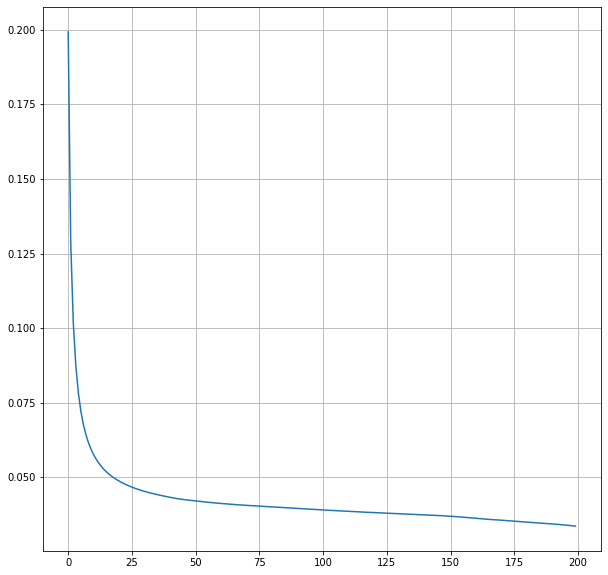

In [10]:
figure = plt.figure(figsize=(10, 10))

plt.plot(losses)
plt.grid(True, which='both')
plt.show()

И посмотрим на наши результаты

In [11]:
preds = predict(model, train_loader)

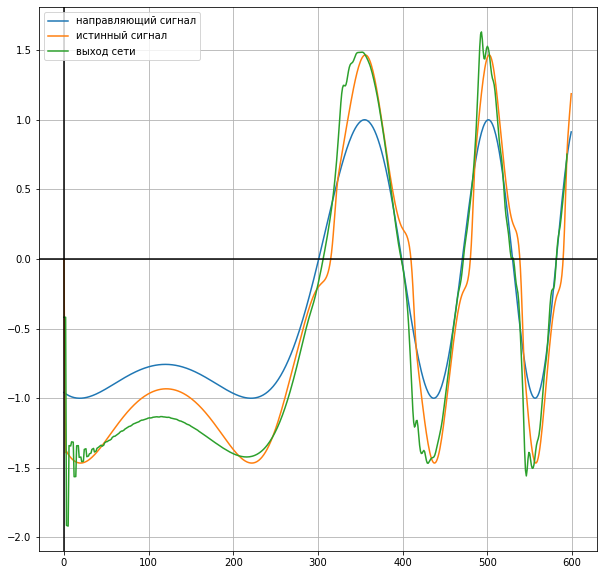

In [12]:
figure = plt.figure(figsize=(10, 10))

plt.plot(uk, label='направляющий сигнал')
plt.plot(yk, label='истинный сигнал')
plt.plot(preds, '-', label='выход сети')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend(loc="upper left")
plt.show()

`Выводы:` в ходе данной работы была построена и обучена нелинейная авторегрессионная сеть с внешними входами, которая была испольована в задаче аппроксимации траектории динамической системы, кроме того при помощи нее был выполнен многошаговый прогноз значений системы. После `200` эпох обучения были получены корректные результаты